<a href="https://colab.research.google.com/github/algroznykh/notebooks/blob/master/%CE%BCNCA_pytorch_compute_codegen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## μNCA: Texture Generation with Ultra-Compact Neural Cellular Automata
### with shader export to compute.toys

*export consts for https://compute.toys/view/359*

(This notebook if a fork of supplementary notebook for ["μNCA: Texture Generation with Ultra-Compact Neural Cellular Automata"](https://arxiv.org/abs/2111.13545) article.)

Copyright 2021 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [ ]:
#@title imports, helpers
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
!pip install -q --progress-bar off einops
from einops import rearrange
!pip install -q --progress-bar off pykeops[colab] geomloss
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from functools import partial

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.ANTIALIAS)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

class LoopWriter(VideoWriter):
  def __init__(self, *a, fade_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(fade_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()


torch.set_default_tensor_type('torch.cuda.FloatTensor')

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

!nvidia-smi -L

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-90467395-3668-c99f-23ec-4540b852dfda)


In [ ]:
# OT loss
from geomloss import SamplesLoss
from torchvision.transforms.functional_tensor import gaussian_blur

def calc_styles_ot(img, ksize, leveln, show=False):
  levels = []
  for i in range(leveln):
    blured = gaussian_blur(img, [5, 5], [1, 1])
    unsharp = img + (img-blured)*2.0
    if show:
      imshow(unsharp[0].permute(1, 2, 0).cpu())
    win = F.unfold(unsharp, ksize).permute(0, 2, 1).contiguous()
    levels.append(win)
    if i<leveln-1:
      img = blured[:,:,::2,::2]
  return levels

opt_f = SamplesLoss()

def subsample(x, n=2048):
  if x.shape[1]>n:
    idx = torch.multinomial(torch.ones(x.shape[1]), n)
    x = x[:,idx]
  return x

def create_ot_loss(target_img, ksize=5, leveln=5, show=False):
  target_style = calc_styles_ot(target_img, ksize, leveln, show)
  def loss_f(imgs):
    xs = calc_styles_ot(imgs, ksize, leveln)
    loss = 0.0
    for x, y in zip(xs, target_style):
      x, y = subsample(x, 1024), subsample(y, 1024*2)
      y = y.repeat(x.shape[0], 1, 1)
      loss += opt_f(x, y).mean()
    return loss
  return loss_f

  warnings.warn(



In [ ]:
# μNCA
side = torch.tensor([[0.0, 0.0,0.0], [2.0,-2.0,0.0], [0.0, 0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])

# filters = [lap]*2+[sobel_x]*1+[sobel_x.T]*1  # 68 params
# filters = [lap]*2+[sobel_x]*2+[sobel_x.T]*2 # 150 params
# filters = [lap]*4+[sobel_x]*2+[sobel_x.T]*2  # 264 params
filters = [lap]*4+[sobel_x]*4+[sobel_x.T]*4  # 588 params

filters = torch.stack(filters)[:,None]
CHN = len(filters)

class CA(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.w = torch.nn.Parameter(torch.randn(CHN, 4*CHN+1, 1, 1)*1e-3)

  def to_rgb(self, x):
    return x[...,:3,:,:]+0.5

  def forward(self, x, update_rate=1.0):
    y = torch.nn.functional.pad(x, [1, 1, 1, 1], 'circular')
    y = torch.nn.functional.conv2d(y, filters, groups=y.shape[1])  # 12 hidden channels
    y = torch.cat([x, y], 1)
    y = y = torch.cat([y, y.abs()], 1)
    #y = torch.cat([y.relu(), -(-y).relu()], 1)
    w, b = self.w[:,:-1], self.w[:,-1,0,0]
    y = torch.nn.functional.conv2d(y, w, b)
    if update_rate<1.0:
      y *= (torch.rand(*y.shape)+update_rate).floor()
    return x+y, y

def seed_f(n, sz=128):
  # return torch.rand(n, CHN, sz, sz)-0.5
  # return torch.zeros(n, CHN, sz, sz)
  return (torch.rand(n, CHN, sz, sz) + .5).floor()  # this is easier to reproduce in a shader

ca = CA()
print('param count:', sum(p.numel() for p in ca.parameters()))

param count: 588


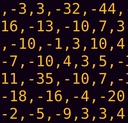

In [ ]:
# target
url = 'https://i.imgur.com/eixCjnM.png'

with torch.no_grad():
  style_img = imread(url, max_size=128)[..., :3]
  texture_loss_f = create_ot_loss(to_nchw(style_img))
imshow(style_img)

In [ ]:
#@title setup training
ca = CA()
opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 4000], 0.3)
loss_log = []
with torch.no_grad():
  pool = seed_f(256)
!rm *.pt

In [ ]:
torch.backends.cudnn.benchmark = True

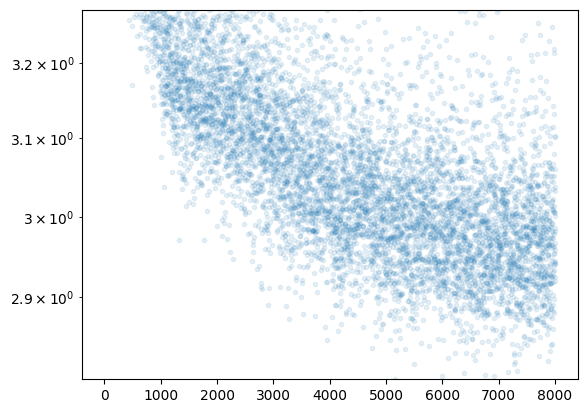

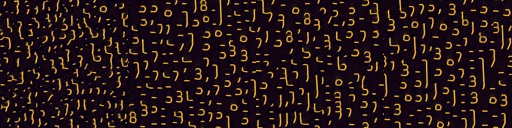

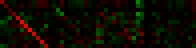

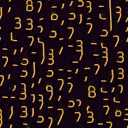

step_n: 8015  loss: 3.189748525619507  lr: 8.999999999999999e-05

KeyboardInterrupt: ignored

In [74]:
#@title training loop {vertical-output: true}

def loss_f(x):
  loss = texture_loss_f(ca.to_rgb(x))
  reg = (x-x.clamp(-1.0, 1.0)).square().sum()
  total_loss = loss + reg
  return total_loss, loss

best_long_loss = np.inf
best_long_step = 0

for i in range(10000):
  batch_idx = np.random.choice(len(pool), 4, replace=False)
  x = pool[batch_idx]
  if i%8 == 0:
    x[:1] = seed_f(1)
  step_n = np.random.randint(32, 128)
  torch.autograd.set_grad_enabled(True)
  for _ in range(step_n):
    x, dx = ca(x)
    x.register_hook(partial(F.normalize, dim=[1,2,3]))
  total_loss, loss = loss_f(x)
  total_loss.backward()
  with torch.no_grad():
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients
    opt.step()
    opt.zero_grad()
    lr_sched.step()
    pool[batch_idx] = x                # update pool

    loss_log.append(loss.item())
    if i%64==0:
      clear_output(True)

      min_loss = np.min(loss_log)
      pl.plot(loss_log, '.', alpha=0.1)
      if min_loss > 0.0:
        pl.yscale('log')
      pl.ylim(min_loss, loss_log[len(loss_log)//5])
      pl.show()
      imgs = ca.to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(imgs))
      pl.show()
      p = ca.w.cpu()[:,:,0,0]
      vis = torch.stack([(-p).relu(), p.relu(), 0.0*p], -1)
      vis *= 1.0/vis.max()
      imshow(zoom(vis))
      pl.show()

      # show long-term behaviour
      x = seed_f(1)
      for _ in range(3000):
        x, _ = ca(x)
      img = ca.to_rgb(x)[0].permute(1, 2, 0).cpu()
      imshow(img)
      _, long_loss = loss_f(x.clip(-1, 1))
      if long_loss<best_long_loss and len(loss_log)-best_long_step > 100:
        torch.save(ca, 'ca_%05d.pt'%len(loss_log))
        best_long_loss = long_loss
        best_long_step = len(loss_log)

    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        ' loss:', loss.item(),
        ' lr:', lr_sched.get_lr()[0], end='')

  for k in tnrange(1000, leave=False):



  0%|          | 0/1000 [00:00<?, ?it/s]

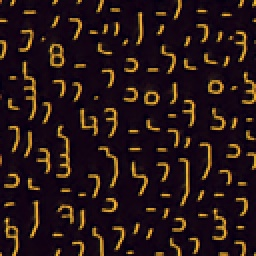

In [75]:
# μNCA pattern after 1000 steps
with torch.no_grad():
  x = seed_f(1, 128)
  ca1 = torch.load('ca_%05d.pt'%best_long_step)
  for k in tnrange(1000, leave=False):
    x, _ = ca1(x)
  img = ca1.to_rgb(x)[0].permute(1, 2, 0).cpu()
  imshow(zoom(img, 2))

In [76]:
#@title μNCA dynamics evolution video {vertical-output: true}
with torch.no_grad():
  ca1 = torch.load('ca_%05d.pt'%best_long_step)
with LoopWriter('final_ca.mp4', fade_len=0.5) as vid, torch.no_grad():
  x = seed_f(1, 128)
  #x[:] = 0.0
  #x[:,:,100, 100] = 1.0
  for k in tnrange(400, leave=False):
    img = ca.to_rgb(x)[0].permute(1, 2, 0).cpu()
    vid.add(zoom(img, 2))
    step_n = int(min(2**(k/30), 8))
    for i in range(step_n):
      x, _ = ca1(x)
vid.show()

  for k in tnrange(400, leave=False):



  0%|          | 0/400 [00:00<?, ?it/s]

In [82]:
 # print consts for compute.toys https://compute.toys/view/359

with torch.no_grad():
  ca1 = torch.load('ca_%05d.pt'%best_long_step)

if len(filters) == 12:
  w_scale = 5000
  n_channels = len(filters)
  with torch.no_grad():
    ws, bs = ca1.w[:,:-1,0,0], ca1.w[:,-1,0,0]
    weight = (ws.T*w_scale).round().cpu()
    bias = (bs*w_scale).round().cpu()

code = ["""const N = {}u;""".format(len(filters))]
code.append("const S = {}.;".format(w_scale))
code.append("const B = array<i32, {}> ({});".format(n_channels, ",".join(str(int(b)) for b in bias )) )

wa_end = "\n"  # use "" for compact repr
w_arrays = "\n"
indent = " " * 8
for a in weight:
  w_arrays += indent + "array<i32, {}>({}),{} ".format(n_channels, ",".join(str(int(w)) for w in a), wa_end)

code.append("const W = array<array<i32, 12>, 48>(" +
            "{}".format("".join(w_arrays)) +
            ");")


print("\n".join(code))
print("\n" * 4)

const N = 12u;
const S = 5000.;
const B = array<i32, 12> (-223,-207,-200,-87,-102,86,164,-71,-45,-69,-164,195);
const W = array<array<i32, 12>, 48>(
        array<i32, 12>(-641,-36,29,-23,41,363,155,46,76,-26,-87,309),
         array<i32, 12>(-89,-397,15,24,125,230,132,123,62,-53,9,194),
         array<i32, 12>(73,31,-283,-177,400,-33,-136,130,119,75,74,-92),
         array<i32, 12>(95,69,7,-494,-70,-150,-194,128,-56,-178,104,-136),
         array<i32, 12>(-1,-68,-85,71,-941,13,-256,34,-100,58,-78,22),
         array<i32, 12>(-37,-181,-10,269,98,-1148,-399,371,-178,-125,-58,-75),
         array<i32, 12>(3,-23,36,-52,205,262,-1095,-215,-248,151,-76,-257),
         array<i32, 12>(-105,-120,36,81,196,8,88,-1167,76,94,-179,11),
         array<i32, 12>(106,89,21,-16,58,56,31,174,-1039,119,-38,-61),
         array<i32, 12>(-248,-186,-53,-128,33,-55,48,-38,106,-821,-59,-96),
         array<i32, 12>(-223,-211,-2,-28,32,-64,-87,202,42,-25,-1028,233),
         array<i32, 12>(-221,-191,-33,112,90